In [291]:
# Module Name: pima_indian_diabetes.py

import pandas as pd
import numpy as np

#EDA-chart / 수치화,결측처리-> corr()
import matplotlib.pyplot as plt
import seaborn as sns

#전처리 : outlier, scale(정규/표준), encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Binarizer #pd.get_dummpy()

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import Xg.. li...
# from sklearn.metrics import mean_squared_error ... mse rmse mas rmsle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

In [292]:
def myscore(y_test, pred, proba=None):
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    auc = roc_auc_score(y_test, proba[:,1].reshape(-1,1))
    print("정확도:{:.4f},재현율:{:.4f},정밀도:{:.4f},f1:{:.4f},auc:{:.4f}".format(accuracy,recall,precision,f1,auc))
    print("confusion:", confusion)

In [293]:
df = pd.read_csv("diabetes.csv")
y = df.iloc[:,-1]
X = df.iloc[:,:-1]
print(X.shape, y.shape)
print(df.info())

(768, 8) (768,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


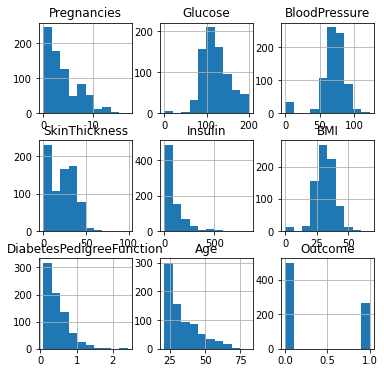

In [294]:
df.hist(figsize=(6,6))
plt.show()

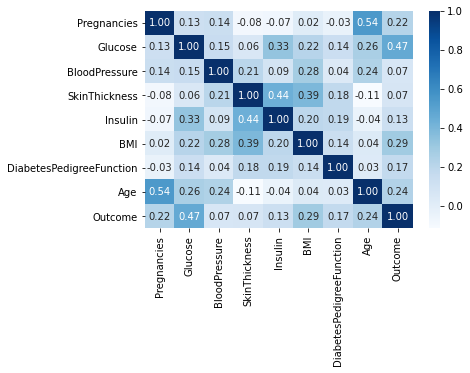

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [295]:
#============= EDA(상관분석)
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='0.2f')
plt.show()
print(df.columns)

* 타켓과 상관도가 높은 피쳐<br>
'Outcome' : 'Glucose','BMI','Age'<br>
* 다중공선x , 주요있게 살펴야할 피쳐<br>
'Age' : 'Pregnancies'<br>
'Insulin' : 'SkinThickness', 'Glucose'   


### 데이터 전처리 전 우선 점수부터 확인
* 숫치형으로만 이루어진 데이터
* 결측이 없는 데이터

In [296]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=160)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)
print("전처리 전 우선 점수부터 확인------\n")
myscore(y_test, pred, proba)

전처리 전 우선 점수부터 확인------

정확도:0.7662,재현율:0.6471,정밀도:0.6471,f1:0.6471,auc:0.8243
confusion: [[85 18]
 [18 33]]


In [297]:
#============= 전처리 : oulier 일환 = 0값 찾기
features = X.columns
for feature in features:
    zero_cnt = X[X[feature]==0][feature].count()
    print(feature, zero_cnt, zero_cnt/df.shape[0]*100)


Pregnancies 111 14.453125
Glucose 5 0.6510416666666667
BloodPressure 35 4.557291666666666
SkinThickness 227 29.557291666666668
Insulin 374 48.69791666666667
BMI 11 1.4322916666666665
DiabetesPedigreeFunction 0 0.0
Age 0 0.0


In [298]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [299]:
zero_column = features[1:6]  #['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print(zero_column)

zero_column_mean = X[zero_column].mean().round(0)
X[zero_column] = X[zero_column].replace(0, zero_column_mean)

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], dtype='object')


In [300]:
#------------ 0값 평균값으로 대체 : 변경확인 -----------
for feature in X.columns:
    zero_cnt = X[X[feature]==0][feature].count()
    print(feature, zero_cnt, zero_cnt/X.shape[0]*100)

Pregnancies 111 14.453125
Glucose 0 0.0
BloodPressure 0 0.0
SkinThickness 0 0.0
Insulin 0 0.0
BMI 0 0.0
DiabetesPedigreeFunction 0 0.0
Age 0 0.0


In [301]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=160)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)
print("평균값 채운 후 점수 확인------\n")
myscore(y_test, pred, proba)

평균값 채운 후 점수 확인------

정확도:0.7662,재현율:0.6471,정밀도:0.6471,f1:0.6471,auc:0.8184
confusion: [[85 18]
 [18 33]]


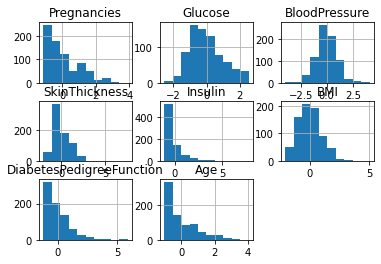

In [302]:
#============= 정규화 : 평균0 분산1로 스케일 조정
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
X_scaler_df = pd.DataFrame(X_scaler, columns=X.columns)
X_scaler_df.hist()
plt.show()

In [303]:
X_train,X_test,y_train,y_test = train_test_split(X_scaler_df, y, test_size=0.2, random_state=160)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)
print(pred[:10])  #당뇨인지 아닌지 내가 예측한거
print(proba[:10])

print("정규화 후 점수 확인------\n")
myscore(y_test, pred, proba)

[0 0 1 1 1 1 0 0 0 0]
[[0.87 0.13]
 [0.75 0.25]
 [0.37 0.63]
 [0.24 0.76]
 [0.33 0.67]
 [0.21 0.79]
 [0.9  0.1 ]
 [0.78 0.22]
 [0.91 0.09]
 [0.81 0.19]]
정규화 후 점수 확인------

정확도:0.7662,재현율:0.6863,정밀도:0.6364,f1:0.6604,auc:0.8266
confusion: [[83 20]
 [16 35]]


#### 정밀도_재현율 커브 곡선 ( 임계치 확인용 )

67 67 66


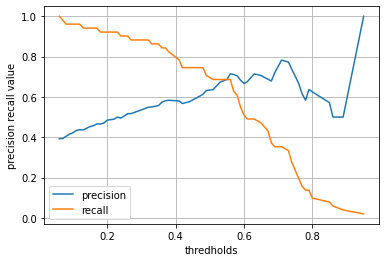

In [304]:
pscore,rscore,th = precision_recall_curve(y_test, proba[:,-1])
print(len(pscore), len(rscore), len(th)) #58 58 57

plt.plot(th, pscore[:len(th)], label="precision")
plt.plot(th, rscore[:len(th)], label="recall")
plt.xlabel("thredholds")
plt.ylabel("precision recall value")
plt.legend()
plt.grid()
plt.show()

In [305]:
thresholds = [0.3,0.4,0.5,0.55, 0.6]
for th in thresholds:
    binarizer = Binarizer(threshold=th)
    pred = binarizer.fit_transform(proba[:,-1].reshape(-1,1))
    
    print("Negative:Positive",th,1-th)  #, pred[:10], proba[:10])#P.s
    myscore(y_test, pred, proba)
    

Negative:Positive 0.3 0.7
정확도:0.7143,재현율:0.8824,정밀도:0.5422,f1:0.6716,auc:0.8266
confusion: [[65 38]
 [ 6 45]]
Negative:Positive 0.4 0.6
정확도:0.7403,재현율:0.7843,정밀도:0.5797,f1:0.6667,auc:0.8266
confusion: [[74 29]
 [11 40]]
Negative:Positive 0.5 0.5
정확도:0.7662,재현율:0.6863,정밀도:0.6364,f1:0.6604,auc:0.8266
confusion: [[83 20]
 [16 35]]
Negative:Positive 0.55 0.44999999999999996
정확도:0.8052,재현율:0.6863,정밀도:0.7143,f1:0.7000,auc:0.8266
confusion: [[89 14]
 [16 35]]
Negative:Positive 0.6 0.4
정확도:0.7532,재현율:0.4902,정밀도:0.6757,f1:0.5682,auc:0.8266
confusion: [[91 12]
 [26 25]]


#### roc_curv() 커브 곡선 ( 임계치 확인용 )

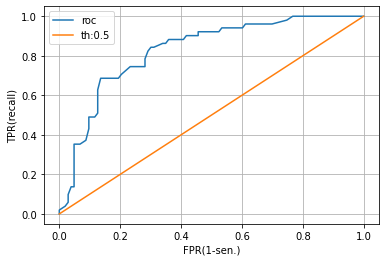

In [306]:

fpr,tpr,th = roc_curve(y_test, proba[:,-1]) #th: max(score_len) + 1
plt.plot(fpr, tpr, label="roc")
plt.plot([0,1], [0,1], label="th:0.5")
plt.xlabel("FPR(1-sen.)")
plt.ylabel("TPR(recall)")
plt.legend()
plt.grid()
plt.show()


In [307]:
auc = roc_auc_score(y_test, proba[:,-1].reshape(-1,1))
print("AUC Score:", auc)

AUC Score: 0.8265752903102989


### 단일 모델 
* 평가  / 검증 / 튜닝


* 5.2. KNN<br>
n_neighbors: Number of neighbors to use by default for k_neighbors queries
model_KNN = KNeighborsClassifier()
neighbors = [1,2,3,4]
param_grid = dict(n_neighbors=neighbors)
<br>
* 5.3. SVC<br>
C: The Penalty parameter C of the error term.
Kernel: Kernel type could be linear, poly, rbf or sigmoid.
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()
<br>
* 5.4. Decision Tree<br>
param_grid = dict(max_depth = 4, min_samples_leaf = 6,
                  criterion = ["gini", "entropy"])
model_CART = DecisionTreeClassifier()
 <br>
* 5.5 AdaBoostClassifier <br>
learning_rate: Learning rate shrinks the contribution of each classifier by learning_rate.
n_estimators: Number of trees to build. <br>

learning_rate_value = [.01,.05,.1,.5, 1]
n_estimators_value = [50,100,150,200,250,300]

model_Ad = AdaBoostClassifier()

* 5.1.Logistic Regression<br>
C(L2 규제) 값이 클수록 규제강도가 커진다(오버피팅 피하기) <br>
L2 - 릿지 - 왜곡,편중,이상치 데이터가 많은 경우 <br>
L1 - 라쏘 - 불필요한 피쳐수를 줄이는 경우 <br>

C : Regularization value, the more, the stronger the regularization(double).<br>
RegularizationType: Can be either "L2" or “L1”. Default is “L2”.

In [308]:
#X_train,X_test,y_train,y_test
def fit_predict(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    myscore(y_test, pred, proba)

from sklearn.linear_model import LogisticRegression
penalty = ['l2']  #['l1', 'l2']
C= [0.5, 1.0, 3.0]

for p in penalty:
    for c in C:
        print("규제, 강도", p, c)
        model = LogisticRegression(random_state=11,penalty=p, C=c)
        fit_predict(model)

규제, 강도 l2 0.5
정확도:0.7987,재현율:0.6471,정밀도:0.7174,f1:0.6804,auc:0.8222
confusion: [[90 13]
 [18 33]]
규제, 강도 l2 1.0
정확도:0.7987,재현율:0.6471,정밀도:0.7174,f1:0.6804,auc:0.8218
confusion: [[90 13]
 [18 33]]
규제, 강도 l2 3.0
정확도:0.7987,재현율:0.6471,정밀도:0.7174,f1:0.6804,auc:0.8212
confusion: [[90 13]
 [18 33]]


* 5.6 GradientBoosting

In [309]:
from sklearn.ensemble import GradientBoostingClassifier
# cv=5
learning_rate_value = [1.0]
n_estimators_value = [100,300,500,600]
# for c in cv:  #GridsearchCV와 다르다.(같은 데이터를 5번 학습)
for lr in learning_rate_value:
    for est in n_estimators_value:
        print("lr, 트리갯수", lr, est)
        model = GradientBoostingClassifier(random_state=11,learning_rate=lr, n_estimators=est)
        fit_predict(model)


lr, 트리갯수 1.0 100
정확도:0.6948,재현율:0.5882,정밀도:0.5357,f1:0.5607,auc:0.7797
confusion: [[77 26]
 [21 30]]
lr, 트리갯수 1.0 300
정확도:0.7468,재현율:0.7059,정밀도:0.6000,f1:0.6486,auc:0.7896
confusion: [[79 24]
 [15 36]]
lr, 트리갯수 1.0 500
정확도:0.7403,재현율:0.7255,정밀도:0.5873,f1:0.6491,auc:0.7942
confusion: [[77 26]
 [14 37]]
lr, 트리갯수 1.0 600
정확도:0.7403,재현율:0.7059,정밀도:0.5902,f1:0.6429,auc:0.7952
confusion: [[78 25]
 [15 36]]


* 5.7 XGBoost, LightGBM, Nueal Network 

In [310]:
from xgboost import XGBClassifier
n_estimators_value = [100,300,500]
max_depth = [3,5,7]
#과적합 :: min_child_weight(작게) / gamma(노드분기:크게)
#         eta(learnrate:작게)
for est in n_estimators_value:
    for depth in max_depth:
        print("트리갯수, 트리깊이", est, depth)
        model = XGBClassifier(objective="binary:logistic",
                            #early_stopping_rounds=10,
                            eval_metric="auc",
                            n_estimators=est,
                            max_depth = depth
        )
        fit_predict(model)


트리갯수, 트리깊이 100 3
정확도:0.7273,재현율:0.6471,정밀도:0.5789,f1:0.6111,auc:0.8104
confusion: [[79 24]
 [18 33]]
트리갯수, 트리깊이 100 5
정확도:0.7143,재현율:0.6471,정밀도:0.5593,f1:0.6000,auc:0.7933
confusion: [[77 26]
 [18 33]]
트리갯수, 트리깊이 100 7
정확도:0.7143,재현율:0.6471,정밀도:0.5593,f1:0.6000,auc:0.7738
confusion: [[77 26]
 [18 33]]
트리갯수, 트리깊이 300 3
정확도:0.7143,재현율:0.6275,정밀도:0.5614,f1:0.5926,auc:0.7811
confusion: [[78 25]
 [19 32]]
트리갯수, 트리깊이 300 5
정확도:0.7078,재현율:0.5882,정밀도:0.5556,f1:0.5714,auc:0.7792
confusion: [[79 24]
 [21 30]]
트리갯수, 트리깊이 300 7
정확도:0.7208,재현율:0.6471,정밀도:0.5690,f1:0.6055,auc:0.7700
confusion: [[78 25]
 [18 33]]
트리갯수, 트리깊이 500 3
정확도:0.7208,재현율:0.6078,정밀도:0.5741,f1:0.5905,auc:0.7811
confusion: [[80 23]
 [20 31]]
트리갯수, 트리깊이 500 5
정확도:0.7143,재현율:0.5882,정밀도:0.5660,f1:0.5769,auc:0.7712
confusion: [[80 23]
 [21 30]]
트리갯수, 트리깊이 500 7
정확도:0.7273,재현율:0.6667,정밀도:0.5763,f1:0.6182,auc:0.7651
confusion: [[78 25]
 [17 34]]


### Ensemble : Voting 

In [311]:
from sklearn.ensemble import VotingClassifier

# model1 = LogisticRegression()
# model8 = RandomForestClassifier()

model_1 = GradientBoostingClassifier(random_state=11,learning_rate=1.0, n_estimators=600)        
model_2 = XGBClassifier(objective="binary:logistic",
                            #early_stopping_rounds=10,
                            eval_metric="auc",
                            n_estimators=100,
                            max_depth = 3
        )

model_list = [('GB',model_1), ('XGB',model_2)]
ensemble_model = VotingClassifier(model_list, voting='soft')

ensemble_model.fit(X_train, y_train)
pred = ensemble_model.predict(X_test)
proba = ensemble_model.predict_proba(X_test)
myscore(y_test, pred, proba)


# score5 = cross_val_score(ensemble_model, X, y, cv=5)  #, scoring='f1')
# print('평균정확도: ',score5.mean())


정확도:0.7468,재현율:0.7451,정밀도:0.5938,f1:0.6609,auc:0.8115
confusion: [[77 26]
 [13 38]]


### 하이퍼파라미터 튜닝

In [316]:
hyper_param = { "n_estimators":[5,10,50,100] #,200,300,400], 
                "max_depth":[3,4,5,6,7,8]}
model = XGBClassifier(objective="binary:logistic",
                            #eval_metric="auc",
                            #n_estimators=est,
                            #max_depth = depth
        )
grid_model = GridSearchCV(estimator=model,
                          param_grid=hyper_param,
             scoring='roc_auc',  refit=True, cv=5, verbose=0)
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_score_)



{'max_depth': 3, 'n_estimators': 10}
0.8355303141809619


### Stacking

In [313]:
##